# Load Environment

In [21]:
%load_ext autoreload
%autoreload 2
%pylab
from IPython.display import set_matplotlib_formats
%matplotlib inline
%config InlineBackend.figure_format='svg'
import seaborn
seaborn.reset_orig()
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 4

import numpy as np
from optalg.opt_solver import *
import scipy.io # to read matlab files

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [22]:
from mppfnet.mp_network import MPNetwork
from mppfnet.mp_problem import MPProblem
import mppfnet
import gridopt
import pfnet

# Load Network
Construct multi-period network and load topology

In [23]:
mp = MPNetwork(timesteps=24)
mp.load('./data/case32.art')

## Set Prices
Load EEX prices from a `.mat` file and set the bus prices accordingly.

In [24]:
prices = scipy.io.loadmat('./data/eex_intraday_2010_3600s.mat')['eex_intraday_2010_3600s']
eex_prices = np.array([p[0,0] for p in prices[:, 5][1:]])
mp.set_prices(eex_prices)

## Set Load Profiles
Read load profiles form a `.csv` generated with [ALPG](https://github.com/GENETX/alpg).

In [25]:
mp.load_load_profile_from_csv("./data/Electricity_Profile.csv")

## Set Solar Profiles
Generates and sets solar profiles from [PVWatts](http://pvwatts.nrel.gov/)

In [26]:
mp.generate_solar_profiles()

# Optimization Problem

Define bus voltage angles as variables (except the slack bus)

In [27]:
mp.set_flags(pfnet.OBJ_BUS, pfnet.FLAG_VARS, pfnet.BUS_PROP_NOT_SLACK, pfnet.BUS_VAR_VANG)

Set batteries power $P$ and energy $E$ as variables

In [29]:
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS,pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_E)
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS,pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_P)

Set generator powers as variables

In [30]:
mp.set_flags(pfnet.OBJ_GEN, pfnet.FLAG_VARS, pfnet.GEN_PROP_NOT_SLACK,pfnet.GEN_VAR_P)

Set the active power at the slack bus as a variable

In [31]:
mp.set_flags(pfnet.OBJ_GEN, pfnet.FLAG_VARS, pfnet.GEN_PROP_SLACK,pfnet.GEN_VAR_P)

Set the active power of the generators as an optimization variable

In [32]:
mp.set_flags(pfnet.OBJ_GEN,pfnet.FLAG_BOUNDED,pfnet.GEN_PROP_ANY,pfnet.GEN_VAR_P)

Set the power $P$ and the energy $E$ of the battery as bounded

In [33]:
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_E)

## Construct the optimization problem

In [34]:
p = MPProblem(mp)

Add the netcon cost function:
$$f(x) = c_e \cdot (l + p_c + p_d - r)$$

In [35]:
p.add_function(pfnet.FUNC_TYPE_NETCON_COST, 1.0)

Generator Bounds

In [36]:
p.add_constraint(pfnet.CONSTR_TYPE_LBOUND)

DC Power Flow

In [37]:
p.add_constraint(pfnet.CONSTR_TYPE_DCPF)

Battery Dynamics Constraints

In [38]:
p.add_constraint(mppfnet.CONSTR_TYPE_BAT_DYN) 

Analyse the Problem, set the initial point and evaluate the initial point $x_0$

In [87]:
p.analyze()
x = p.get_init_point()
x = p.eval(x)

Show some information about the network:

In [41]:
mp.show_components()

Network Components
-----------------------------
timesteps:           : 24
------- per timestep --------
buses:               : 31
   slack:            : 1
   reg by gen:       : 1
   reg by tran:      : 1
   reg by shunt:     : 0
shunts:              : 0
   fixed:            : 0
   switched v:       : 0
branches:            : 30
   lines:            : 29
   fixed trans:      : 0
   phase shifters    : 0
   tap changers v    : 1
   tap changers Q    : 0
generators:          : 1
   slack:            : 1
   reg:              : 1
   P adjust          : 1
loads:               : 19
   P adjust:         : 0
vargens:             : 2
batteries:           : 3


# Construct optimization problem for linear solver

In [42]:
from optalg.opt_solver.lp_cvxopt import OptSolverLP_CVXOPT
from optalg.opt_solver.linear_problem import LinProblem
from scipy.sparse import triu

In [43]:
Hx = p.Hphi + p.Hphi.T - triu(p.Hphi)
gx = p.gphi - Hx*x
g = gx / mp.base_power
H = Hx / mp.base_power
A = p.A
b = p.b
l = p.l
u = p.u
x = p.x

In [44]:
problem = QuadProblem(H, g, A, b, l, u, x=x)
solver = OptSolverIQP()
solver.set_parameters({'quiet': False, 'tol': 1e-4})
problem.show()

Solve Optimization Problem

In [ ]:
solver.solve(problem)
print(solver.get_status())

Store Solver Result

In [46]:
mp.set_var_values(solver.get_primal_variables())

# Output

In [47]:
%aimport pfvis

## Battery SOC

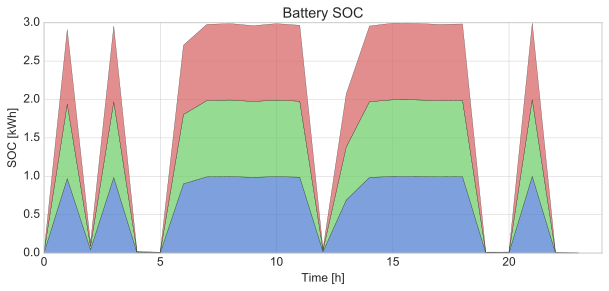

In [48]:
pfvis.plot_battery_soc(mp)

## Battery Power

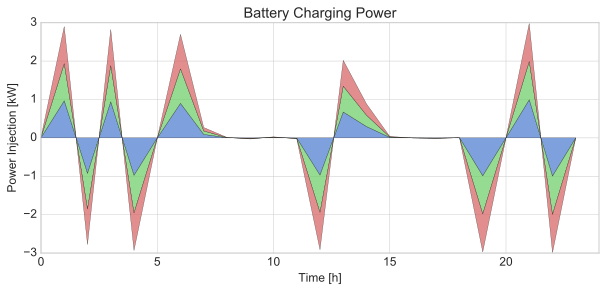

In [49]:
pfvis.plot_battery_power(mp)

## Energy Price

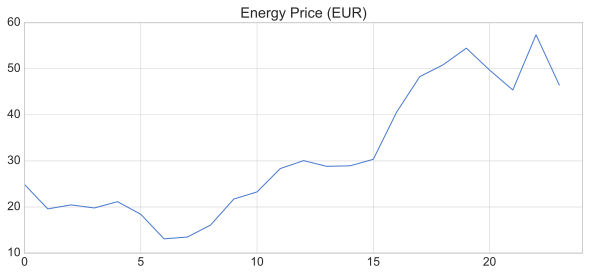

In [50]:
pfvis.plot_energy_price(mp)

## Load Power

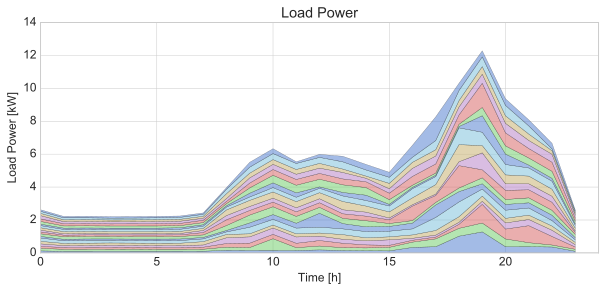

In [51]:
pfvis.plot_load_power(mp)

## Injection by renewable Generation

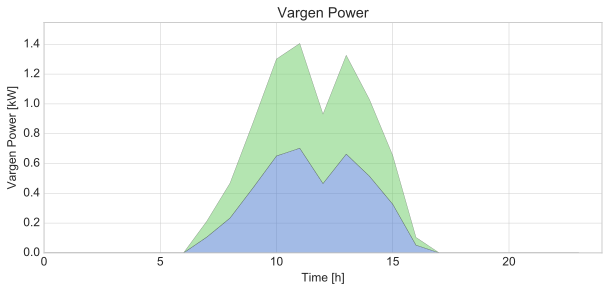

In [52]:
pfvis.plot_vargen_injection(mp)

## Network Graph

In [53]:
#g = pfnet.Graph(mp.networks[0])
#for bus in mp.networks[0].buses:
#    g.set_node_property(bus,b"label",str(bus.number).encode('UTF-8'))
#g.set_layout()    
#g.view(inline=True)

# Distributed Approach

In [54]:
prob = p.problems[0]
prob.analyze()
constraint = prob.constraints[1]
constraint.A.shape

(31, 40)

In [55]:
net = prob.network
net.var_generators[0].index_P

0

Show the structure of $A$

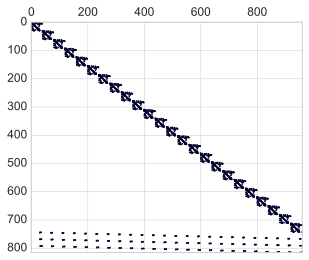

In [56]:
spy(A, precision=0.01, markersize=1)
show()

## Solve Benchmark Centralized QP Problem

In [57]:
nx = A.shape[1]
nc = A.shape[0]

print("Shape of A: {0}".format(A.shape))
print("Shape of b: {0}".format(b.shape))
print("Shape of g: {0}".format(g.shape))
print("Shape of H: {0}".format(H.shape))
print("Shape of l: {0}".format(l.shape))
print("Shape of u: {0}".format(u.shape))

Shape of A: (816, 960)
Shape of b: (816,)
Shape of g: (960,)
Shape of H: (960, 960)
Shape of l: (960,)
Shape of u: (960,)


Set the initial point $x_0$ to be all zeros (flat start)

In [58]:
x = zeros((nx,))

Construct the quadratic problem from $H, g, A, b, l$ and $u$ matricies constructed before

In [59]:
problem = QuadProblem(H, g, A, b, l, u, x=x)
solver = OptSolverIQP()
solver.set_parameters({'quiet': False, 'tol': 1e-4})

Solve the optimization problem and store the primal solution as $x^*$ and the optimal objective value as $p^*$

In [60]:
solver.solve(problem)
xstar = solver.get_primal_variables().copy()
pstar = np.dot(g,xstar)
print("Optimal objective value: {0:.2E} ".format(pstar))
#print(solver.get_dual_variables()[0])
#print(solver.get_primal_variables())


Solver: IQP
-----------
iter    phi      fmax      gmax       cu       cl       s    
 0  0.00e+00  5.74e+01  9.90e+03  1.0e+01  1.0e+01  0.0e+00 
 1  1.55e-03  5.74e+01  9.90e+03  1.0e+01  1.0e+01  2.1e-06 
 2  6.85e-03  5.74e+01  9.90e+03  1.0e+01  1.0e+01  8.4e-06 
 3  1.28e-02  5.74e+01  9.90e+03  1.0e+01  1.0e+01  1.8e-05 
 4  3.32e-02  5.74e+01  9.90e+03  1.0e+01  1.0e+01  1.1e-04 
 5  1.08e-02  5.73e+01  9.89e+03  1.0e+01  1.0e+01  6.0e-04 
 6  4.57e-02  5.72e+01  9.88e+03  1.0e+01  1.0e+01  1.7e-03 
 7  9.09e-03  5.70e+01  9.83e+03  9.9e+00  9.9e+00  4.7e-03 
 8  4.46e-02  5.61e+01  9.69e+03  9.8e+00  9.8e+00  1.4e-02 
 9  9.26e-03  5.37e+01  9.27e+03  9.4e+00  9.4e+00  4.3e-02 
10  4.45e-02  4.69e+01  8.10e+03  8.2e+00  8.2e+00  1.3e-01 
11  9.30e-03  2.98e+01  5.15e+03  5.2e+00  5.2e+00  3.6e-01 
12  4.45e-02  1.26e+00  2.17e+02  3.2e-01  3.2e-01  9.6e-01 

iter    phi      fmax      gmax       cu       cl       s    
12  4.45e-02  1.26e+00  3.06e+02  3.2e-01  3.2e-01  9.6e-

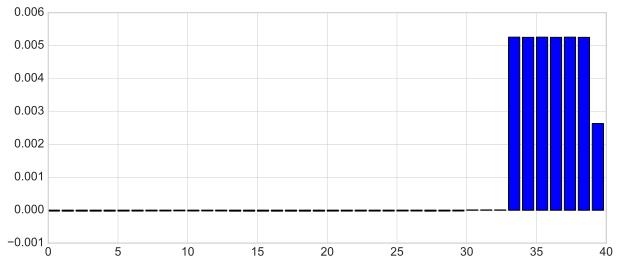

In [84]:
bar(range(mp.networks[0].num_vars), solver.get_primal_variables()[:mp.networks[0].num_vars])
show()

Construct the decoupled subproblem with the DC power balance relaxed in the objective:
    
$$
    \begin{align}\min &&& f(x) \\
    s.t. & && A x = b \\
     & && x_1, \ldots x_n \in \mathcal X_1, \ldots \mathcal X_n
    \end{align}
    $$

In [61]:
import cvxpy
from scipy.sparse import triu,coo_matrix,bmat,eye

# construct decoupled problem
# dc power flow constraints
A = scipy.sparse.block_diag([prob.constraints[1].A for prob in p.problems.values()])
b = np.hstack([prob.constraints[1].b for prob in p.problems.values()])
print("Shape of A: {0}".format(A.shape))
print("Shape of b: {0}".format(b.shape))

# battery dynamics
Abat = scipy.sparse.vstack([p.get_battery_A(battery) for battery in p.net.get_network().batteries])
bbat = np.hstack([p.get_battery_b(battery) for battery in p.net.get_network().batteries])
print("Shape of Abat: {0}".format(Abat.shape))
print("Shape of bbat: {0}".format(bbat.shape))
print("Shape of x: {0}".format(x.shape))

Shape of A: (744, 960)
Shape of b: (744,)
Shape of Abat: (72, 960)
Shape of bbat: (72,)
Shape of x: (960,)


## Dual Gradient Ascent

Initial Values:

In [63]:
lam = np.zeros(A.shape[0])  # really poor dual initial point
x = zeros((nx,)) # poor guess on the initial point

Parameters:

In [64]:
tol = 1e-5
mu = 1.799e-2

In [65]:
print("Solver: Dual Gradient")
print("----------------------------")
print("it  obj         alpha         lmin           lmax         dL/dl         deltax       error")
print("in  {1:.2E}      {2:.2E}         {3:.2E}      {4:.2E}     {5:.2E}      {6:.2E}     {7:.2E}".format(0, g.dot(x),  NaN, min(lam), max(lam),  norm(A*x -b), norm(x - xprev), np.abs(np.dot(g,x)-pstar)/np.abs(pstar)))


for iteration in range(1, 100):
    xprev = x.copy()
    
    alpha = 1 / (iteration + 1)

    # Primal update
    solver = OptSolverIQP()
    
    # Projection on the set
    QPproblem = QuadProblem(H+mu*A.T*A, g-A.T*lam-mu*A.T*b, Abat,bbat,l,u,x=x)
    solver.set_parameters({'quiet':True})
    solver.solve(QPproblem)
    x = solver.get_primal_variables()
    
    # Dual update
    lam += alpha * (b - A*x)
    
    # Print information
    if iteration % 1 == 0:
        print("{0}  {1:.2E}  {2:.2E}      {3:.2E}      {4:.2E}     {5:.2E}      {6:.2E}     {7:.2E}".format(iteration, g.dot(x),  alpha, min(lam), max(lam),  norm(A*x -b), norm(x - xprev), np.abs(np.dot(g,x)-pstar)/np.abs(pstar)))

    # Check for convergence
    if norm(A*x -b) < tol and np.abs(np.dot(g,x)-pstar)/np.abs(pstar) < tol:
        print("Converged")
        print("*  {1:.2E}  {2:.2E}      {3:.2E}      {4:.2E}     {5:.2E}      {6:.2E}     {7:.2E}".format(iteration, g.dot(x),  alpha, min(lam), max(lam),  norm(A*x -b), norm(x - xprev), np.abs(np.dot(g,x)-pstar)/np.abs(pstar)))
        break
        

Solver: Dual Gradient
----------------------------
it  obj         alpha         lmin           lmax         dL/dl         deltax       error
in  0.00E+00      NAN         0.00E+00      0.00E+00     7.61E-03      5.59E+03     1.00E+00
1  -1.68E-01  5.00E-01      -9.49E-08      2.09E-07     9.97E-06      6.91E-02     3.04E-09
Converged
*  -1.68E-01  5.00E-01      -9.49E-08      2.09E-07     9.97E-06      6.91E-02     3.04E-09


Plot a bar plot of $x$

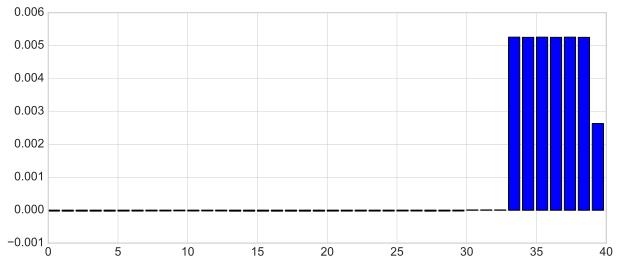

In [83]:
bar(range(mp.networks[0].num_vars), x[:mp.networks[0].num_vars])
show()

## Primal / Dual Gradient Method

In [86]:
print("Solver: Primal/Dual Gradient")
print("----------------------------")
print("it   obj     alphax     alphal         lmin           lmax         dL/dx         dL/dl       deltax        error")

tol = 1e-5

# initial values
lam = np.zeros(A.shape[0])  # really poor dual initial point
x = p.get_init_point()
#x = zeros((nx,))

# scaling factor for augmented term
mu = 1e2
for iteration in range(1, 50000):
    xprev = x.copy()
    
    # gradient wrt. x
    gLx = g-A.T*lam-mu*A.T*b + (H+mu*A.T*A)*x
    # gradient wrt. lam
    gLl = b-A*x
    
    # step sizes
    alphax = 1 / (iteration+1e8)
    alphal = 1 / (iteration+1e10)
    
    y = x - alphax * gLx
    # do the projection

    solver = OptSolverIQP()
    QPproblem = QuadProblem(eye(nx),-2 * y, Abat,bbat,l,u,x=x)
    solver.set_parameters({'quiet':True})
    solver.solve(QPproblem)
    x = solver.get_primal_variables()
    
    lam = lam + alphal*gLl
   
    if iteration < 10 or iteration % 50 == 0:
        print("{0}  {1:.2E}  {2:.2E}   {3:.2E}  {4:.2E}      {5:.2E}     {6:.2E}      {7:.2E}     {8:.2E}      {9:.2E}".format(iteration, np.dot(g, x),  alphax, alphal, min(lam), max(lam), norm(gLx), norm(gLl), norm(x - xprev), np.abs(np.dot(g,x)-pstar)/np.abs(pstar)))
    if norm(A*x -b) < tol and np.abs(np.dot(g,x)-pstar)/np.abs(pstar) < tol:
        print("Converged")
        print("*  {1:.2E}  {2:.2E}   {3:.2E}  {4:.2E}      {5:.2E}     {6:.2E}      {7:.2E}     {8:.2E}      {9:.2E}".format(iteration, np.dot(g, x),  alphax, alphal, min(lam), max(lam), norm(gLx), norm(gLl), norm(x - xprev), np.abs(np.dot(g,x)-pstar)/np.abs(pstar)))
        break

Solver: Primal/Dual Gradient
----------------------------
it   obj     alphax     alphal         lmin           lmax         dL/dx         dL/dl       deltax        error
1  1.02E-01  1.00E-08   1.00E-10  -2.05E-26      1.84E-26     4.10E+02      3.83E-16     5.85E-02      1.61E+00
2  5.08E-02  1.00E-08   1.00E-10  -4.51E-13      4.40E-13     4.04E+03      1.66E-02     5.71E-02      1.30E+00
3  1.22E-01  1.00E-08   1.00E-10  -5.47E-12      6.82E-12     1.29E+05      2.99E-01     1.13E-01      1.73E+00
4  5.61E-02  1.00E-08   1.00E-10  -2.42E-10      2.20E-10     4.97E+06      1.09E+01     2.46E-01      1.33E+00
5  6.22E-03  1.00E-08   1.00E-10  -8.86E-09      8.66E-09     2.03E+08      4.36E+02     4.00E+00      1.04E+00
6  1.02E-01  1.00E-08   1.00E-10  -3.29E-07      3.60E-07     8.62E+09      1.82E+04     1.69E+02      1.61E+00
7  7.43E-02  1.00E-08   1.00E-10  -1.49E-05      1.39E-05     3.73E+11      7.83E+05     1.84E+03      1.44E+00
8  -9.07E-02  1.00E-08   1.00E-10  -5.34E-05 

KeyboardInterrupt: 